In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("chess_games.csv")
df.head()

,game_id,rated,turns,victory_status,winner,time_increment,white_id,white_rating,black_id,black_rating,moves,opening_code,opening_moves,opening_fullname,opening_shortname,opening_response,opening_variation
0,1,False,13,Out of Time,White,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,5,Slav Defense: Exchange Variation,Slav Defense,NaN,Exchange Variation
1,2,True,16,Resign,Black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,4,Nimzowitsch Defense: Kennedy Variation,Nimzowitsch Defense,NaN,Kennedy Variation
2,3,True,61,Mate,White,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,3,King's Pawn Game: Leonardis Variation,King's Pawn Game,NaN,Leonardis Variation
3,4,True,61,Mate,White,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,3,Queen's Pawn Game: Zukertort Variation,Queen's Pawn Game,NaN,Zukertort Variation
4,5,True,95,Mate,White,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,5,Philidor Defense,Philidor Defense,NaN,NaN


# Exploratory Data Analysis 

it's to be noted that the result of this analysis apply to lichess rating (which is known to be inflated compared to chess.com)

In [3]:
df.columns

Index(['game_id', 'rated', 'turns', 'victory_status', 'winner',
       'time_increment', 'white_id', 'white_rating', 'black_id',
       'black_rating', 'moves', 'opening_code', 'opening_moves',
       'opening_fullname', 'opening_shortname', 'opening_response',
       'opening_variation'],
      dtype='object')

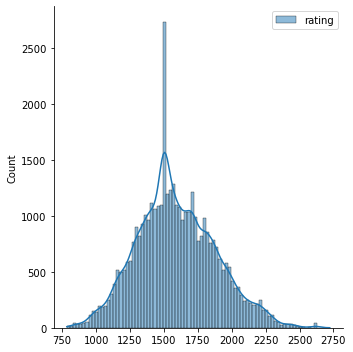

In [4]:
#first let's get the distribution of the ratings of the players
sns.displot(pd.concat([df['white_rating'],df["black_rating"]], axis = 0), label='rating', kde=True)
plt.legend()
plt.show()

In [5]:
#it appears that there are an abnormal amount of players with a rating of around 1500 so let's check for duplicates in the dataset
df.duplicated().sum()

0

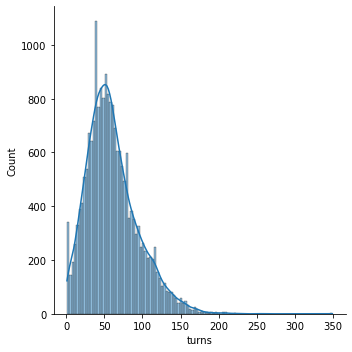

In [6]:
#let's check the distribution of the number of turns in the games
sns.displot(df['turns'], label='turns', kde=True)

In [7]:
#let's check if the number of turns is correlated with the rating of the players
#it appears that the number of games above 150 is about 300 which is not a small number
from sklearn.preprocessing import StandardScaler
from scipy import stats
#we will use correlation coefficient to check the correlation between the number of turns and the rating of the players
#we will use spearman correlation coefficient because the data is not normally distributed
corr = stats.spearmanr(df['turns'], df['white_rating'])
print(corr)
abnormal_turns = df[df['turns'] > 150]
corr = stats.spearmanr(abnormal_turns['turns'], abnormal_turns['white_rating'])
print(corr)

SpearmanrResult(correlation=0.1396652193605909, pvalue=6.498992184721319e-88)
SpearmanrResult(correlation=0.008338662450157944, pvalue=0.8877551143513304)


In [8]:
#though there is a correlation between the number of turns and the rating of the players, it is not expressed in the abnormal number of turns
#maybe it's the opening choice that is correlated with the number of turns
#let's check the distribution of the opening names
print(df['opening_shortname'].value_counts().keys()[0:10],
    abnormal_turns['opening_shortname'].value_counts().keys()[0:10])
#it appears that the most common opening is the same in both cases

Index(['Sicilian Defense', 'French Defense', 'Queen's Pawn Game',
       'Italian Game', 'King's Pawn Game', 'Queen's Gambit', 'Ruy Lopez',
       'English Opening', 'Scandinavian Defense', 'Philidor Defense'],
      dtype='object') Index(['Sicilian Defense', 'Queen's Pawn Game', 'King's Pawn Game',
       'Ruy Lopez', 'Queen's Gambit', 'Italian Game', 'French Defense',
       'Philidor Defense', 'Caro-Kann Defense', 'Indian Game'],
      dtype='object')


In [9]:
#maybe it's the time control that is correlated with the number of turns
df[["time", "increment"]] = df["time_increment"].str.split("+", expand=True)
df["time"] = df["time"].astype(int)
df["increment"] = df["increment"].astype(int)

In [10]:
abnormal_turns = df[df['turns'] > 150]
corr = stats.spearmanr(abnormal_turns['turns'], abnormal_turns['increment'])
print(corr)
corr = stats.spearmanr(abnormal_turns['turns'], abnormal_turns['time'])
print(corr)
median_turns = df['turns'].median()
corr = stats.spearmanr(abnormal_turns['turns'], abnormal_turns['time']+abnormal_turns['increment']*median_turns)
print(corr)

SpearmanrResult(correlation=-0.027288304625535248, pvalue=0.64409801091169)
SpearmanrResult(correlation=-0.04904255308656131, pvalue=0.4061939451953872)
SpearmanrResult(correlation=-0.030213334386625528, pvalue=0.608988752262229)


In [11]:
# t-test between the abnormal games and the normal games 
# get equivalent sample of normal games
normal_turns = df[df['turns'] <= 150]
normal_turns = normal_turns.sample(n=abnormal_turns.shape[0])
print(stats.ttest_ind(abnormal_turns['time'], normal_turns['time']))
print(stats.ttest_ind(abnormal_turns['increment'], normal_turns['increment']))
print(abnormal_turns["increment"].mean(), normal_turns['increment'].mean())

Ttest_indResult(statistic=-1.1765094854956197, pvalue=0.2398773245495024)
Ttest_indResult(statistic=-2.7046760715424845, pvalue=0.007039317358324982)
2.878892733564014 5.3321799307958475


2.878892733564014 4.8743807461659


c:\Users\amrsh\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\amrsh\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='white_rating', ylabel='Density'>

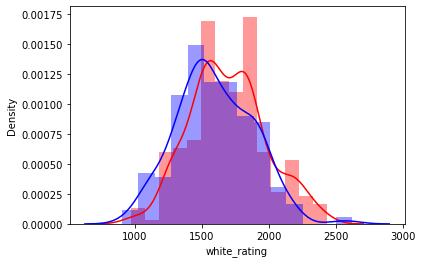

In [12]:
#there is a significant difference between the increment of the abnormal games and the normal games
#so it seems that the increment is the reason for the abnormal number of turns
#maybe when the increment is too low, the players will struggle to finish the game fast
# but that makes more sense when there is fast responses to the moves of the opponent meaning when the players are higher rated
#let's check the distribution of the ratings of the players in the abnormal games vs normal games with the same increment
print(abnormal_turns["increment"].mean(), abnormal_turns['increment'].std())
normal_turns = df[df['turns'] <= 150]
#filter with a z-score of 3 of by the abnormal games distribution
normal_turns = normal_turns[(normal_turns['increment'] - abnormal_turns['increment'].mean()) / abnormal_turns['increment'].std() < 3]
normal_turns = normal_turns.sample(n=abnormal_turns.shape[0])
sns.distplot(abnormal_turns['white_rating'], label='abnormal rating', kde=True, color='red')
sns.distplot(normal_turns['white_rating'], label='normal rating', kde=True, color='blue')

In [13]:
print(stats.ttest_ind(abnormal_turns['white_rating'], normal_turns['white_rating']))
#as we expected, the players with a higher rating tend to have longer games with lower increments 

Ttest_indResult(statistic=4.031742072462256, pvalue=6.281165274326408e-05)


<AxesSubplot:xlabel='winner', ylabel='count'>

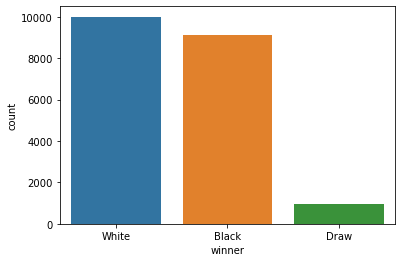

In [14]:
#let's check the distribution of winners in the games
sns.countplot(x='winner', data=df)

<AxesSubplot:xlabel='winner', ylabel='white_rating'>

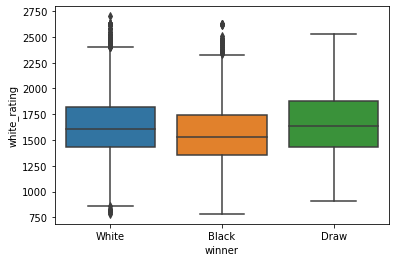

In [15]:
#it looks as expected  with white winning the most and draws being the least
#let's check if there are a relationship between the winner and the rating of the players
sns.boxplot(x='winner', y='white_rating', data=df)
#it appears that the players with a higher rating tend to win more games with white 


<AxesSubplot:xlabel='winner', ylabel='count'>

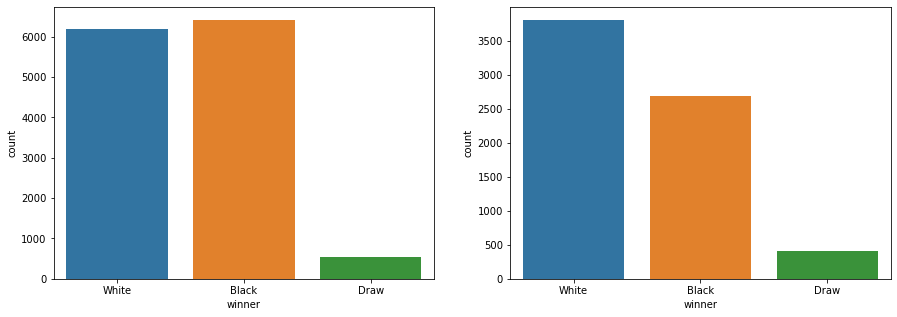

In [16]:
# low rated players even wins more with black than white
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
df_low = df[df['white_rating'] < 1700]
sns.countplot(x='winner', data=df_low, ax=ax[0])
df_high = df[df['white_rating'] > 1700]
sns.countplot(x='winner', data=df_high, ax=ax[1])

In [17]:
#let's check with chi-square test if there is a relationship between the winner and the rating of the players
#we will use chi-square test because the data is categorical
from scipy.stats import chi2_contingency
df_moded = df[df['winner'] != 'Draw']
df_moded["rating"] = df_moded["white_rating"].apply(lambda x: "low" if x < 1700 else "high")
contingency_table = pd.crosstab(df_moded['winner'], df_moded['rating'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(p)
#the p-value is less than 0.05 so there is a relationship between the winner's color and the rating of the players

2.930624966874581e-36


<ipython-input-17-0b4c86e1a00e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_moded["rating"] = df_moded["white_rating"].apply(lambda x: "low" if x < 1700 else "high")


In [18]:
# let's double check with a point biserial correlation coefficient
from scipy.stats import pointbiserialr
corr = pointbiserialr(df_moded['winner'] == "White", df_moded['white_rating'])
print(corr)

PointbiserialrResult(correlation=0.14631364395179253, pvalue=6.516982662305846e-92)


In [19]:
# but does the color matter when the players are low rated?
df_low = df_moded[df_moded['white_rating'] < 1700]
df_low["rating"] = df_low["white_rating"].apply(lambda x: "low" if x < 1700 else "high")
# let's make a proportion test to check if the proportion of white wins is different from the proportion of black wins
from statsmodels.stats.proportion import proportions_ztest
count = np.array([df_low[df_low['winner'] == 'White'].shape[0], df_low[df_low['winner'] == 'Black'].shape[0]])
nobs = np.array([df_low.shape[0], df_low.shape[0]])
stat, pval = proportions_ztest(count, nobs)
print(pval)

0.003058665706890388


<ipython-input-19-e0394c97be0a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_low["rating"] = df_low["white_rating"].apply(lambda x: "low" if x < 1700 else "high")


In [20]:
# it seems that low rated players win more with black than white which is not what we expected
# maybe when the time is high enough, low rated players will be able to win more with white
#let's test if there is a signigicant difference between the won games with white and black when the time is high vs low
df_low["average_time"] = df_low["time"] + df_low["increment"]*df_low["turns"]
df_low["high_time"] = df_low["average_time"] > df_low["average_time"].median()
df_low["high_time"] = df_low["high_time"].apply(lambda x: "high" if x else "low")
contingency_table = pd.crosstab(df_low['winner'], df_low['high_time'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(p)

0.006391833415442996


<ipython-input-20-393a418e20b7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_low["average_time"] = df_low["time"] + df_low["increment"]*df_low["turns"]
<ipython-input-20-393a418e20b7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_low["high_time"] = df_low["average_time"] > df_low["average_time"].median()
<ipython-input-20-393a418e20b7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [21]:
contingency_table

high_time,high,low
winner,,
Black,3115,3298
White,3152,3026


<AxesSubplot:xlabel='winner', ylabel='count'>

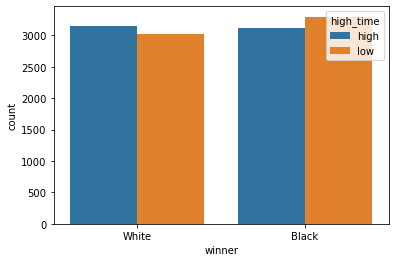

In [22]:
#it seeems there is no significant difference between the won games with white and black when the time is high vs low.
#let's visualize that with a bar plot
sns.countplot(x='winner', hue='high_time', data=df_low)


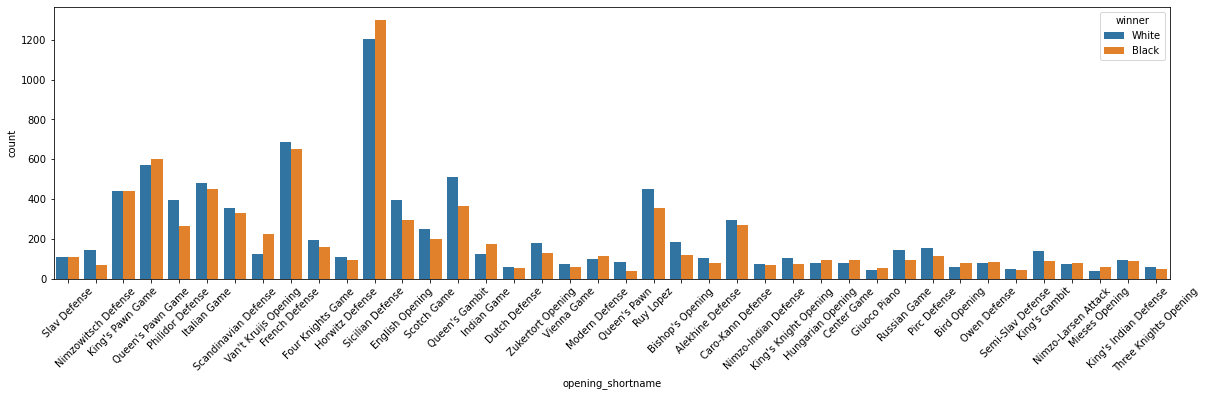

In [65]:
#that's very interesting, it seems that the lower the time the higher the chance of winning with black
#we still didn't examine the relationship between the winner and the opening the player chose
#let's check the first 50 most common openings
common_openings = []
for i,j in df["opening_shortname"].value_counts().head(40).iteritems():
    common_openings.append(i)
df_common = df[df["opening_shortname"].isin(common_openings)]
df_common = df_common[df_common["winner"] != "Draw"]
plt.figure(figsize=(20, 5))
plt.xticks(rotation=45)
sns.countplot(x='opening_shortname', hue='winner', data=df_common)
plt.show()

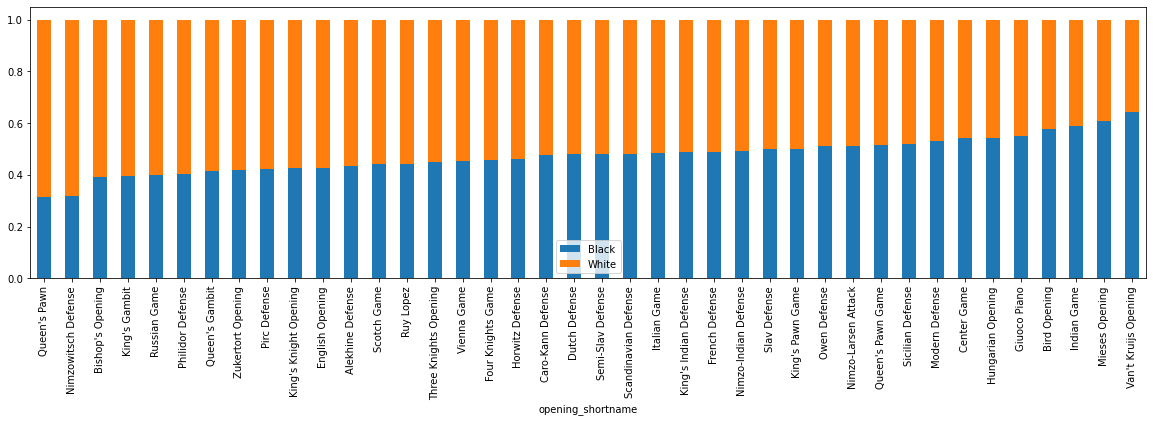

In [66]:
#the previous plot is not very readable, let's try to make a plot with the percentage of wins for each opening
common_grb = df_common.groupby(["opening_shortname", "winner"]).size().unstack()
percent_common = common_grb.div(common_grb.sum(axis=1), axis=0)
percent_common.sort_values(by="White", ascending=False, inplace=True)
percent_common.plot(kind='bar', stacked=True, figsize=(20, 5))
plt.legend()

In [67]:
# we can clearly see which openings are mostly winning for white and which are mostly winning for black
# but that depends on the sample size of each opening, let's make a confidence interval for each opening and see if there is a significant difference between the winning percentage of white and black
def get_conf_int(p, z, n):
    return p - z * np.sqrt(p * (1 - p) / n), p + z * np.sqrt(p * (1 - p) / n)

conf_intervals = {}
for i in percent_common.index:
    p = percent_common["White"].loc[i]
    z = 1.96
    #calculate the confidence interval
    conf_intervals[i] = get_conf_int(p, z, dict(df_common["opening_shortname"].value_counts())[i])

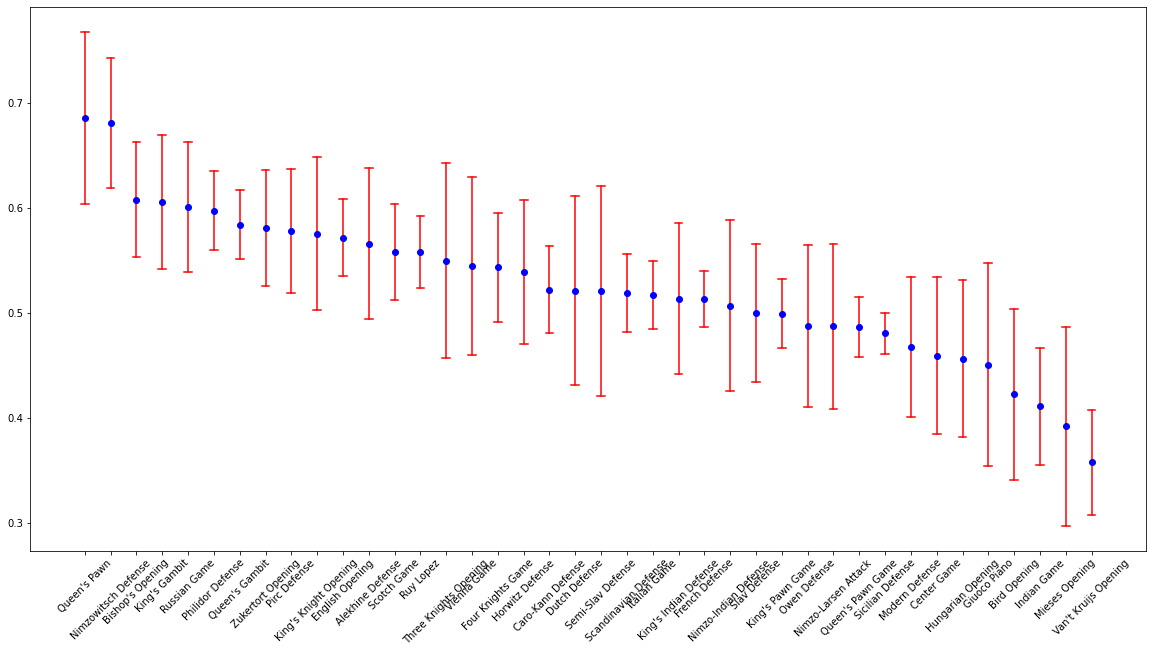

In [68]:
def plot_confidence_interval(conf_intervals):
    tick = 1 
    for k, v in conf_intervals.items():
        lower, upper = v
        plt.plot([tick,tick], [lower, upper], color="red")
        plt.plot(tick, (lower+upper)/2, "o", color="blue")
        plt.plot([tick-0.15, tick+0.15], [lower, lower], color="red")
        plt.plot([tick-0.15, tick+0.15], [upper, upper], color="red")
        tick += 1
    plt.xticks(list(range(1, tick)), conf_intervals.keys(), rotation=45)
    plt.show()
plt.figure(figsize=(20,10))
plot_confidence_interval(conf_intervals)